In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from scipy.stats import norm, gmean, cauchy
import seaborn as sns
from datetime import datetime, timedelta

%matplotlib inline

In [52]:
def import_stock_data(tickers, start = '2010-1-1', end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tickers]) ==1:
        data[tickers] = wb.DataReader(tickers, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for t in tickers:
            data[t] = wb.DataReader(t, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [51]:
data = import_stock_data(['AMD','NVDA','M'])

In [4]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [5]:
log_return = log_returns(data)

In [6]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [7]:
drift = drift_calc(data)

In [8]:
stdev = log_returns(data).std().values

In [9]:
def get_tickers(data):
    tickers = [i for i in data.columns]
    return tickers
tickers=get_tickers(data)
tickers

['AMD', 'NVDA', 'M', '^GSPC']

In [10]:
def probs_find(predicted, higherthan, ticker = None, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted: dataframe with all the predicted prices (days and simulations)
    2. higherthan: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    4. ticker: specific ticker to compute probability for
    """
    if ticker == None:
        if on == 'return':
            predicted0 = predicted.iloc[0,0]
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
            less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
        elif on == 'value':
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [i for i in predList if i >= higherthan]
            less = [i for i in predList if i < higherthan]
        else:
            print("'on' must be either value or return")
    else:
        if on == 'return':
            predicted = predicted[predicted['ticker'] == ticker]
            predicted0 = predicted.iloc[0,0]
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
            less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
        elif on == 'value':
            predicted = predicted.iloc[-1]
            predList = list(predicted)
            over = [i for i in predList if i >= higherthan]
            less = [i for i in predList if i < higherthan]
        else:
            print("'on' must be either value or return")        
    return (len(over)/(len(over)+len(less)))

In [11]:
def montecarlo_cholesky(tickers, days, iterations, start='2010-1-1', show_hist = False, show_line = False, show_stats=True):
    #Get tickers and number of tickers involved in this portfolio
    data = import_stock_data(tickers, start=start)
    ticks = get_tickers(data)
    numstocks = len(ticks)
    
    #Basic information and data
    log_return = log_returns(data)
    
    #Brownian motion component: drif
    drift = drift_calc(data)
    stdev = log_returns(data).std().values
    
    #Cholesky decomposition
    covari = log_return.cov()
    chol = np.linalg.cholesky(covari)
    
    #Generate uncorralated random variables and use cholesky decomposition to correlate them
    uncorr_x = norm.ppf(np.random.rand(numstocks,iterations*days))
    corr_x = np.dot(chol, uncorr_x)
    
    #Calculate daily return
    corr_2 = np.zeros_like(corr_x)
    for i in range(numstocks):
        corr_2[i] = np.exp(drift[i] + corr_x[i])
    simulatedDF = []    
    #For every stock, calculate the returns
    for s in range(len(ticks)):
        ret_reshape = corr_2[s]
        ret_reshape = ret_reshape.reshape(days,iterations)
        price_list = np.zeros_like(ret_reshape)
        price_list[0] = data.iloc[-1,s]
        #Calculate returns for the s stock
        for t in range(1,days):
            price_list[t] = price_list[t-1]*ret_reshape[t]
        
        #Create dataframe for this run, input the name of stock and load
        y = pd.DataFrame(price_list)   
        y['ticker'] = tickers[s]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
        
        #plotting
        if show_hist == True:
            x = pd.DataFrame(price_list).iloc[-1]
            fig, ax = plt.subplots(1,2, figsize=(14,4))
            sns.distplot(x, ax=ax[0],axlabel="Stock Price")
            sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
            plt.xlabel("Stock Price")
            plt.show()
        if show_line == True:
            y = pd.DataFrame(price_list[:,0:10]).plot(figsize=(15,6))
        
        if show_stats == True:
        #Printing basic stats
            print(ticks[s])
            print(f"Days: {days}")
            print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),2)}")
            print(f"Return: {round(100*(pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean(),2)}%")
            print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
   
        
    simulatedDF = pd.concat(simulatedDF)
    return(simulatedDF)

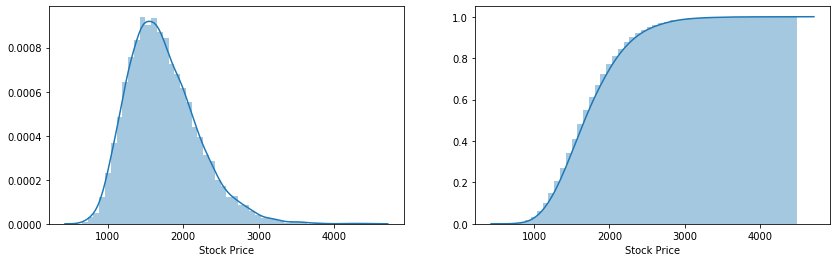

GOOG
Days: 252
Expected Value: $1729.86
Return: 16.85%
Probability of Breakeven: 0.7144


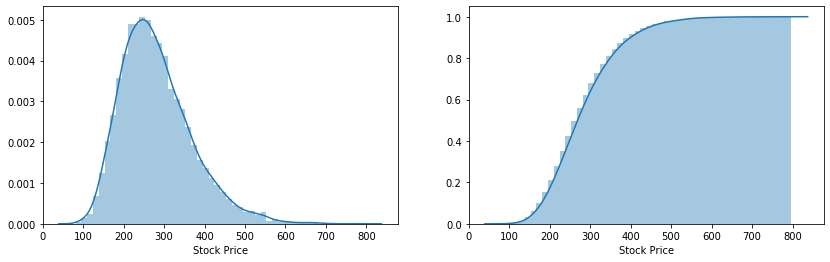

FB
Days: 252
Expected Value: $281.45
Return: 18.01%
Probability of Breakeven: 0.6909


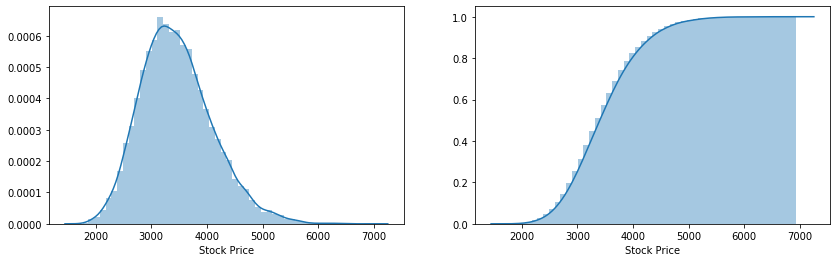

^GSPC
Days: 252
Expected Value: $3460.76
Return: 7.71%
Probability of Breakeven: 0.6319


In [12]:
x = montecarlo_cholesky(['GOOG','FB','^GSPC'], days=252, iterations=10000, start='2015-1-1', show_hist=True)

In [13]:
x

,ticker,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,GOOG,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,...,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015,1438.390015
1,GOOG,1445.572316,1403.739083,1423.293929,1391.051997,1467.204514,1453.787444,1431.952171,1507.618640,1437.841184,...,1428.415317,1465.985092,1446.407635,1401.520606,1404.414667,1486.075177,1474.621344,1464.174681,1435.937438,1465.277560
2,GOOG,1431.756829,1401.036684,1412.559306,1367.359281,1480.806439,1446.893329,1448.879886,1447.754583,1446.002861,...,1452.540400,1441.008275,1431.190586,1397.965569,1350.284944,1497.579196,1469.696888,1494.929513,1467.191050,1496.160393
3,GOOG,1439.733309,1432.742908,1422.479815,1348.280500,1469.460158,1443.576412,1495.411187,1454.324648,1432.557946,...,1468.151022,1445.848223,1447.396167,1398.986202,1380.545707,1503.569496,1454.723876,1494.835619,1458.801427,1474.302230
4,GOOG,1444.817918,1476.820319,1399.585205,1349.468004,1407.861757,1433.712291,1487.216359,1464.927878,1391.781114,...,1507.139638,1454.597563,1457.808349,1459.388952,1398.909042,1488.203537,1423.114788,1471.130541,1461.376071,1456.863202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,^GSPC,2753.873502,3611.415640,3501.990961,3882.237937,2346.052416,2910.498896,3412.450220,2662.888836,2701.381139,...,2717.701959,3820.656061,3100.911669,4092.468145,3560.274452,4156.573386,2749.697638,3488.353065,4004.260400,3386.129515
248,^GSPC,2778.787606,3668.506510,3518.952014,3932.197811,2391.244683,2887.936796,3403.481674,2734.668828,2712.240225,...,2710.162749,3855.040736,3128.659945,4149.059481,3553.064301,4210.472682,2769.730880,3445.540272,3994.076103,3433.214108
249,^GSPC,2775.489391,3617.255764,3555.818307,3999.698034,2391.632606,2861.261556,3366.031658,2743.877947,2688.257655,...,2724.729678,3884.139844,3140.611331,4143.406126,3576.748879,4293.613073,2708.353494,3448.552361,4042.017231,3391.681816
250,^GSPC,2795.029626,3623.765587,3554.375791,3969.089651,2385.604002,2861.798315,3419.398968,2720.369041,2668.122848,...,2701.413019,3866.049444,3196.309556,4130.762884,3578.849162,4205.659931,2744.147953,3443.104430,4055.094605,3322.528970


In [24]:
[col for col in data.columns]

['AMD', 'NVDA', 'M', '^GSPC']

## Sharpe Ratio

In [36]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    ticks = [col for col in data.columns]
    if mark_ticker in ticks:
        ann_return = np.exp(log_returns(data).mean()*252).values-1
    else:
        market_data = import_stock_data(mark_ticker, start)
        market_rets = log_returns(market_data).dropna()
        ann_return = np.exp(market_rets.mean()*252).values-1
        data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [37]:
a,b=market_data_combination(data)

In [38]:
def beta_sharpe(data, mark_ticker = "^GSPC", start='2010-1-1', riskfree = 0.025, riskpremium = 0.05):
    # Beta
    dd, mark_ret = market_data_combination(data, mark_ticker, start) #load data and annual returns
    log_ret = log_returns(dd) # create the logarithmic returns of the data
    covar = log_ret.cov()*252 #Annualized covariance matrix 
    covar = pd.DataFrame(covar.iloc[:-1,-1]) # Get the part of the covariance matrix that is related between the stocks and the market
    mrk_var = log_ret.iloc[:,-1].var()*252 # Annualized variance of market
    beta = covar/mrk_var # Now we have our betas!
    
    #Add the standard deviation to the beta dataframe
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # Get tickers of all the stocks in the dataframe used
    tickers = get_tickers(dd)
    
    # Make dictionary for the annual return of each stock
    mark_ret = {tickers[i]:mark_ret[i] for i in range(len(tickers))}
    

    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret[mark_ticker]-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [39]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
AMD,1.558355,0.569753,0.149193,0.217978
NVDA,1.459855,0.420283,0.141343,0.276822
M,1.182713,0.408784,0.119257,0.230578


In [40]:
data.head()

,AMD,NVDA,M,^GSPC
Date,,,,
2010-01-04,9.70,17.010056,11.740423,1132.989990
2010-01-05,9.71,17.258446,11.602788,1136.520020
2010-01-06,9.57,17.368835,11.767951,1137.140015
2010-01-07,9.47,17.028448,12.036343,1141.689941
2010-01-08,9.43,17.065248,11.644078,1144.979980


# Portfolio Optimization

First, we will create a portfolio optimizer that determines the allocation of weights among data that we have - data that is not generated.

Second, we will replicate the same portfolio algorythm, only this time with the average predicted values of all the runs into the future. 

In [41]:
data.head()

,AMD,NVDA,M,^GSPC
Date,,,,
2010-01-04,9.70,17.010056,11.740423,1132.989990
2010-01-05,9.71,17.258446,11.602788,1136.520020
2010-01-06,9.57,17.368835,11.767951,1137.140015
2010-01-07,9.47,17.028448,12.036343,1141.689941
2010-01-08,9.43,17.065248,11.644078,1144.979980


In [42]:
log_return = log_returns(data)

weights = np.array(np.random.random(4))
weights = weights/np.sum(weights)

expected_ret = np.sum((log_return.mean()*weights)*252)

expected_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))

sharpe = (expected_ret-0.025)/expected_vol

print(f"Weights: {weights}")
print(f"Expected Return of Portfolio: {expected_ret}")
print(f"Expected Volatility: {expected_vol}")
print(f"Sharpe Ratio: {sharpe}")

Weights: [0.26708833 0.21839189 0.320964   0.19355578]
Expected Return of Portfolio: 0.11775551777245691
Expected Volatility: 0.3027864574300374
Sharpe Ratio: 0.3063397173035364


In [44]:
def market_data_combination(data, mark_ticker = "^GSPC", start='2010-1-1'):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [54]:
import_stock_data(['MSFT','AMZN'])

,MSFT,AMZN
Date,,
2010-01-04,24.226894,133.899994
2010-01-05,24.234720,134.690002
2010-01-06,24.085989,132.250000
2010-01-07,23.835503,130.000000
2010-01-08,23.999893,133.520004
...,...,...
2020-06-01,182.830002,2471.040039
2020-06-02,184.910004,2472.409912
2020-06-03,185.360001,2478.399902


In [55]:
def montecarlo_sharpe_optimal_portfolio(tickers, trials, riskfree=0.025, plot_eff = True, start_date = '2010-1-1', end_date=None):
    if end_date == None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    data = import_stock_data(tickers)
    allWeights = np.zeros((trials, len(data.columns)))
    allReturns = np.zeros(trials)
    allVolatility = np.zeros(trials)
    allSharpeValues = np.zeros(trials)
    
    log_return = log_returns(data)
    
    for t in range(trials):
        weights = np.random.rand(len(data.columns))
        weights = weights/np.sum(weights) 
        allWeights[t,:]=weights
        
        allReturns[t] = np.sum((log_return.mean()*weights)*252)
        
        allVolatility[t] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov()*252, weights)))
        
        allSharpeValues[t] = (allReturns[t]-riskfree)/allVolatility[t]
    
    maxsharpe = allSharpeValues.max()
    pointsharpe = allSharpeValues.argmax()
    weightSharpe = allWeights[pointsharpe]
    x_sharpe = allVolatility[pointsharpe]
    y_sharpe = allReturns[pointsharpe]
    
    maxret = allReturns.max()
    pointret = allReturns.argmax()
    weightRet = allWeights[pointret]
    x_ret = allVolatility[pointret]
    y_ret = allReturns[pointret]
    
 
    if plot_eff == True:
        plt.figure(figsize=(14,9))
        plt.scatter(allVolatility, allReturns, c=allSharpeValues, cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Expected Return')
        
        plt.scatter(x_sharpe,y_sharpe,c='black')
        plt.scatter(x_ret, y_ret, c='black')
       
    optim_dic = []
    for i in range(len(tickers)):
        optim_dic.append({'ticker':tickers[i],'Weight':weightSharpe[i]})
    print(pd.DataFrame(optim_dic))

  ticker    Weight
0   MSFT  0.393259
1    UNH  0.606741


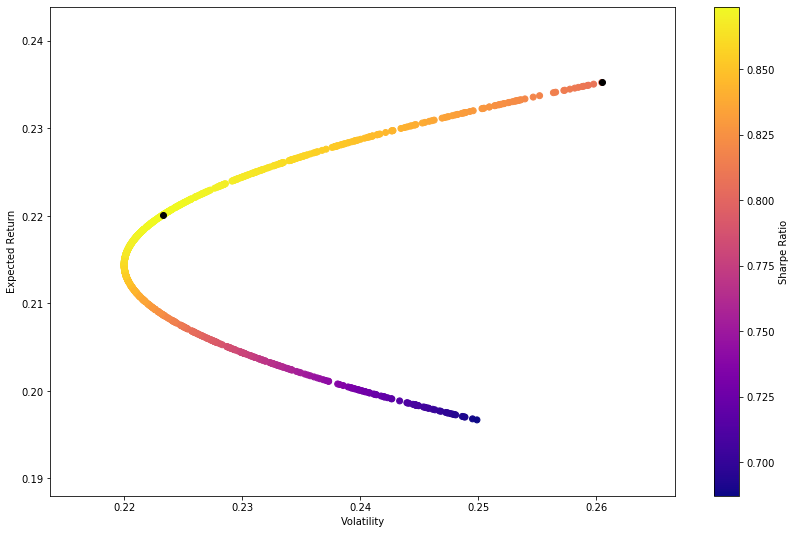

In [58]:
montecarlo_sharpe_optimal_portfolio(['MSFT','UNH'],1000)

In [ ]:
import_stock_data(['MSFT','AMZN','AMZN'])